
---

### Dataset yang dipakai:
1. Dataset [Data Pinjaman] - Sumber [https://www.kaggle.com/datasets/ardykaaw/data-pinjaman]
---

### Codingan :

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
import os
import pandas as pd
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz-12.2.1-win64/bin/'
warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
df = pd.read_csv("DATA PINJAMAN.csv")
df_clean = df.drop(columns=["ID_Nasabah"])
target = "StatusPinjaman"
X = df_clean.drop(columns=[target])
y = df_clean[target]
df.head()

,ID_Nasabah,JenisKelamin,StatusPernikahan,JumTanggungan,Pendidikan,Wiraswasta,IncomeNasabah,IncomePasangan,JumlahPinjaman,JangkaWaktuPinjaman,Credit_History,WilayahTempatTinggal,StatusPinjaman
0,LP001002,Male,No,0.0,Graduate,No,5849,0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0,141.0,360.0,1.0,Urban,Y


In [26]:
df.describe()

,JumTanggungan,IncomeNasabah,IncomePasangan,JumlahPinjaman,JangkaWaktuPinjaman,Credit_History
count,599.000000,614.000000,614.000000,592.000000,600.00000,564.000000
mean,0.762938,5403.459283,1621.245928,146.412162,342.00000,0.842199
std,1.015216,6109.041673,2926.248406,85.587325,65.12041,0.364878
min,0.000000,150.000000,0.000000,9.000000,12.00000,0.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,0.000000,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,2.000000,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,3.000000,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_Nasabah            614 non-null    object 
 1   JenisKelamin          601 non-null    object 
 2   StatusPernikahan      611 non-null    object 
 3   JumTanggungan         599 non-null    float64
 4   Pendidikan            614 non-null    object 
 5   Wiraswasta            582 non-null    object 
 6   IncomeNasabah         614 non-null    int64  
 7   IncomePasangan        614 non-null    int64  
 8   JumlahPinjaman        592 non-null    float64
 9   JangkaWaktuPinjaman   600 non-null    float64
 10  Credit_History        564 non-null    float64
 11  WilayahTempatTinggal  614 non-null    object 
 12  StatusPinjaman        614 non-null    object 
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ KB


In [28]:
# Buat kolom TotalIncome dan transformasi log
df["TotalIncome"] = df["IncomeNasabah"] + df["IncomePasangan"]
df["TotalIncome_log"] = np.log(df["TotalIncome"] + 1)  # +1 untuk hindari log(0)

In [29]:
# Transformasi log JumlahPinjaman
df["JumlahPinjaman_log"] = np.log(df["JumlahPinjaman"])

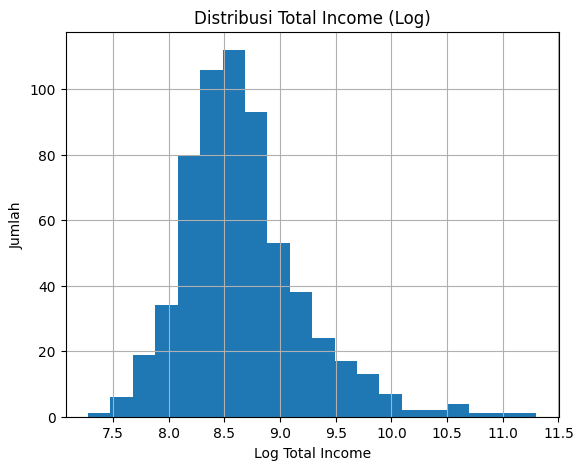

In [30]:
# Visualisasi histogram log
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
df["TotalIncome_log"].hist(bins=20)
plt.title("Distribusi Total Income (Log)")
plt.xlabel("Log Total Income")
plt.ylabel("Jumlah")
plt.show()

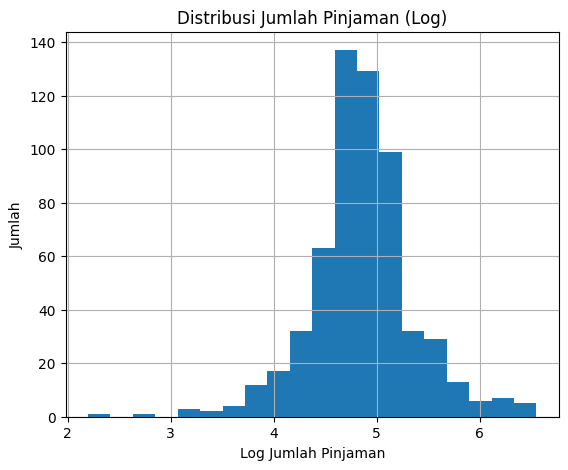

In [31]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
df["JumlahPinjaman_log"].hist(bins=20)
plt.title("Distribusi Jumlah Pinjaman (Log)")
plt.xlabel("Log Jumlah Pinjaman")
plt.ylabel("Jumlah")
plt.show()

In [32]:
# 2. Preprocessing
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

In [33]:
# Encode label target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [34]:
# Preprocess features
X_preprocessed = preprocessor.fit_transform(X)

In [57]:
# 3. Split & SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [36]:
# 4. Feature Selection + Modeling
rf_model = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf_model, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train_smote, y_train_smote)
X_test_rfe = rfe.transform(X_test)

rf_model.fit(X_train_rfe, y_train_smote)

RandomForestClassifier(random_state=42)

In [37]:
# 5. Evaluation
y_pred = rf_model.predict(X_test_rfe)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
               precision    recall  f1-score   support

           N       0.69      0.63      0.66        38
           Y       0.84      0.87      0.86        85

    accuracy                           0.80       123
   macro avg       0.76      0.75      0.76       123
weighted avg       0.79      0.80      0.79       123



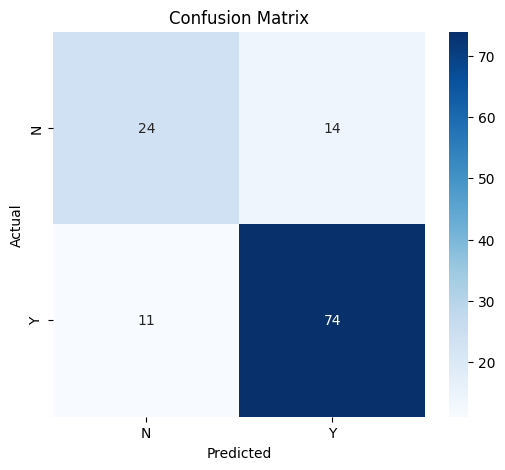

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [39]:
# Cross-validation
cv_scores = cross_val_score(rf_model, X_train_rfe, y_train_smote, cv=5)
print("Average Cross-Validation Accuracy: {:.2f}%".format(cv_scores.mean() * 100))

Average Cross-Validation Accuracy: 82.50%
